ANOVA Test Results:
F-statistic: 280.79
P-value: 0.0000
Conclusion: There is a statistically significant difference in average salaries between continents.
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
    group1        group2      meandiff   p-adj     lower        upper    reject
-------------------------------------------------------------------------------
       Africa          Asia  -14282.1865 0.9147  -54591.0976  26026.7247  False
       Africa        Europe    20809.578 0.6297  -17393.8183  59012.9743  False
       Africa North America   94245.3788    0.0   56528.7261 131962.0315   True
       Africa       Oceania   20778.0714 0.8462  -29397.0413  70953.1842  False
       Africa South America  -12011.8452 0.9792  -59363.5695   35339.879  False
         Asia        Europe   35091.7645    0.0   19214.9535  50968.5754   True
         Asia North America  108527.5653    0.0   93860.6118 123194.5188   True
         Asia       Oceania   35060.2579  0.

/tmp/ipykernel_142/2888381260.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_salary.values, y=avg_salary.index, palette='crest')


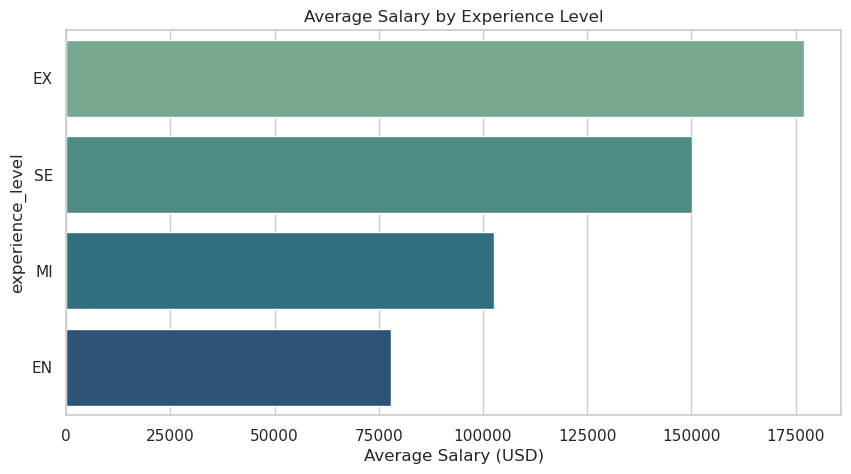

/tmp/ipykernel_142/2888381260.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_salary.values, y=avg_salary.index, palette='crest')


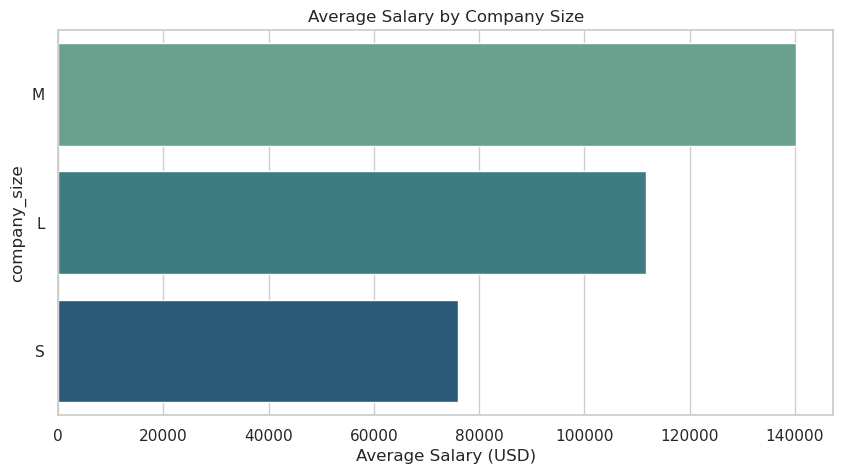

/tmp/ipykernel_142/2888381260.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_salary.values, y=avg_salary.index, palette='crest')


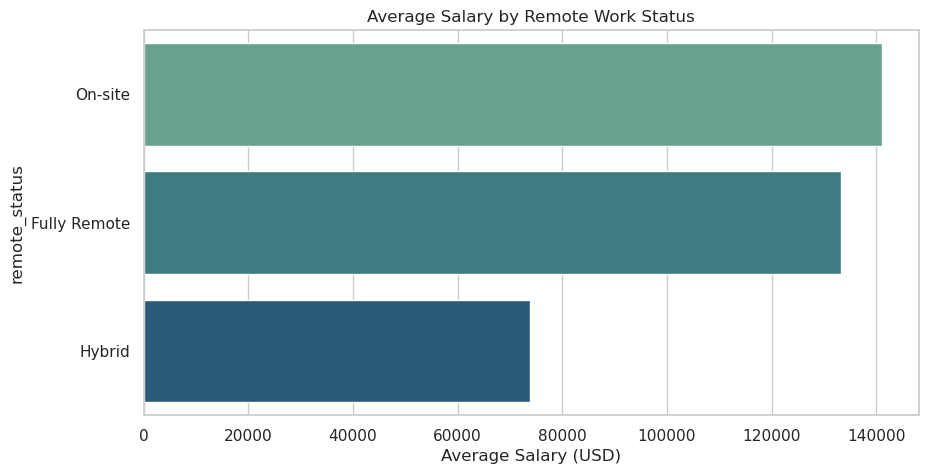

/tmp/ipykernel_142/2888381260.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_salary.values, y=avg_salary.index, palette='crest')


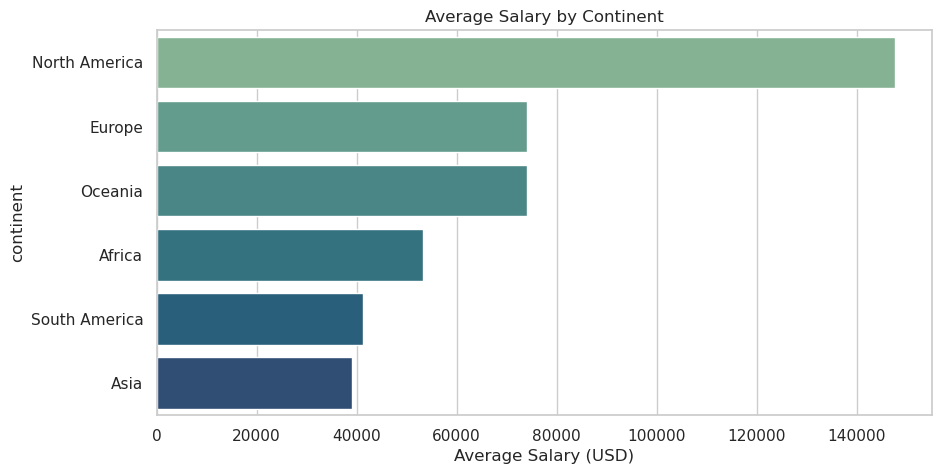

/tmp/ipykernel_142/2888381260.py:185: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


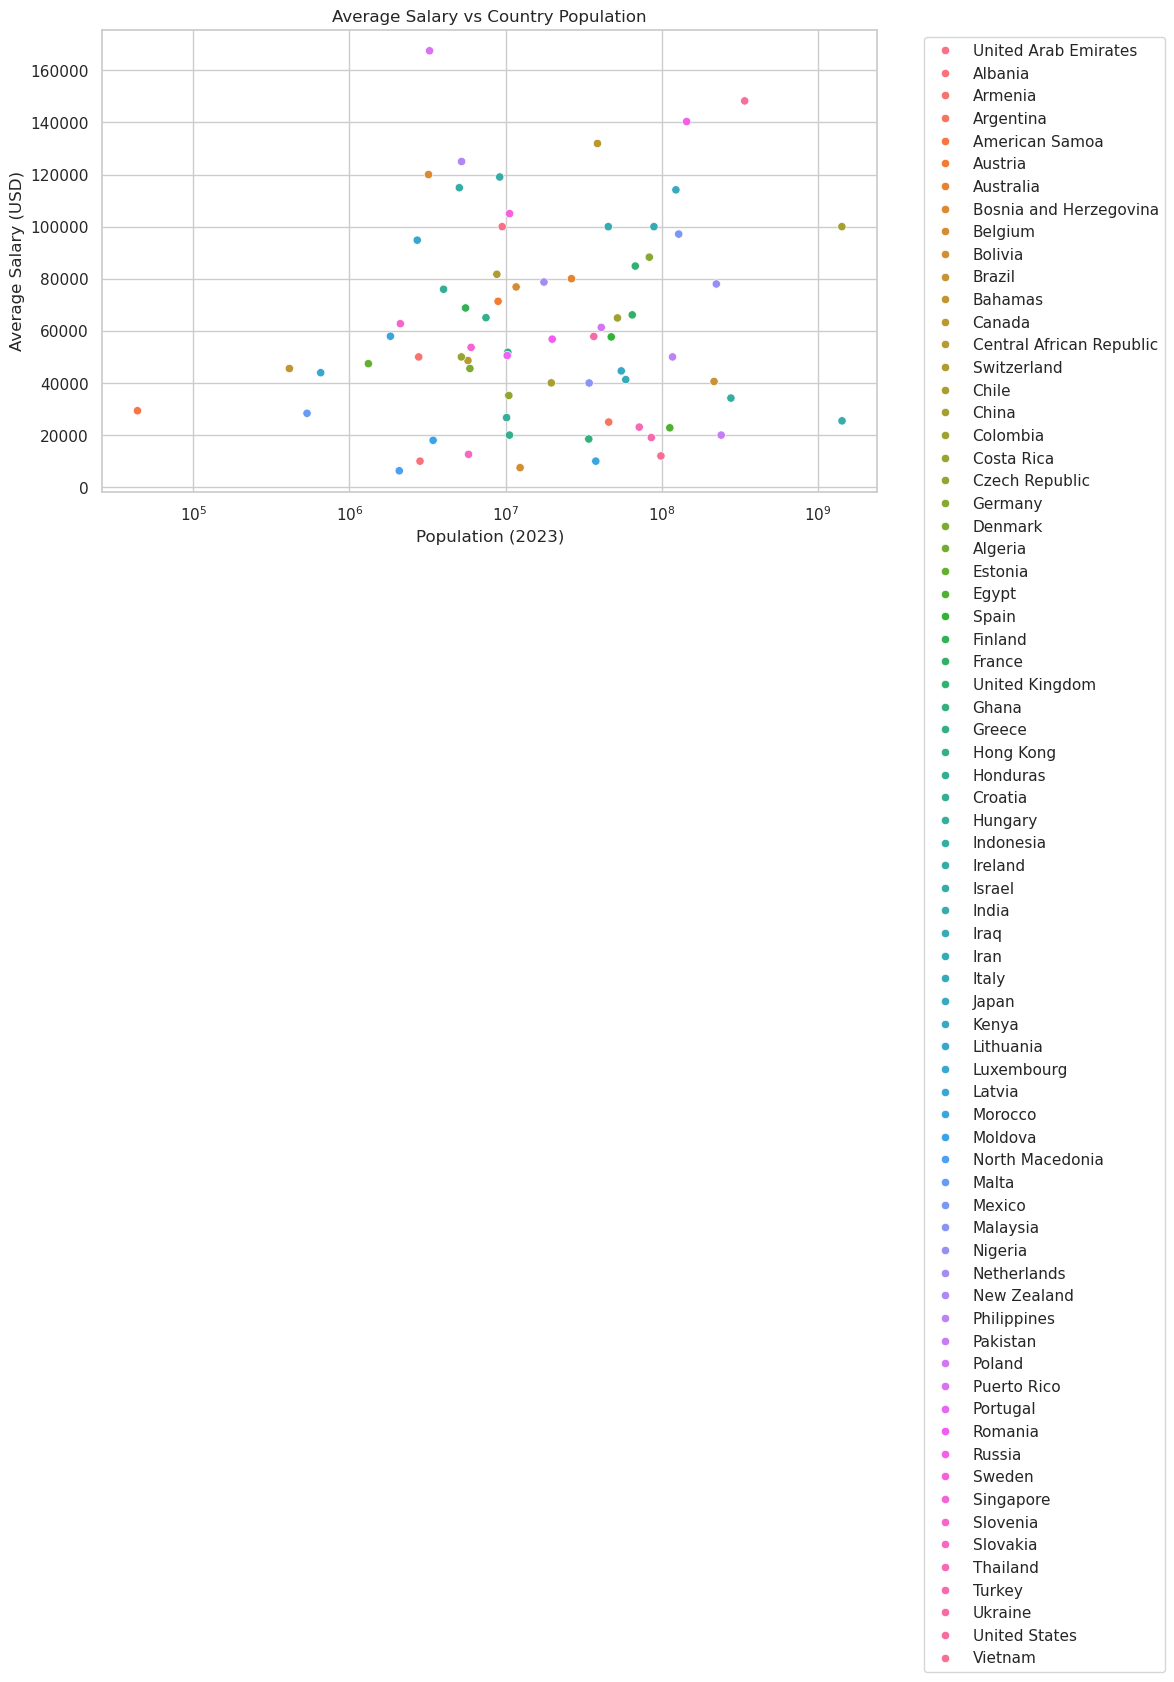

/tmp/ipykernel_142/2888381260.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=salaries_cleaned.dropna(subset=['continent']), x='continent', y='salary_in_usd', palette='pastel')


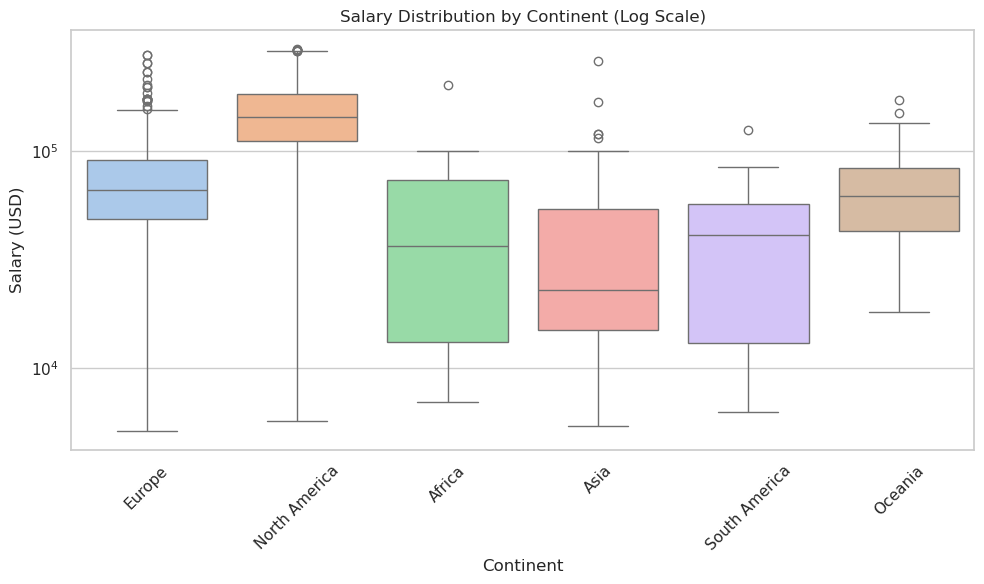

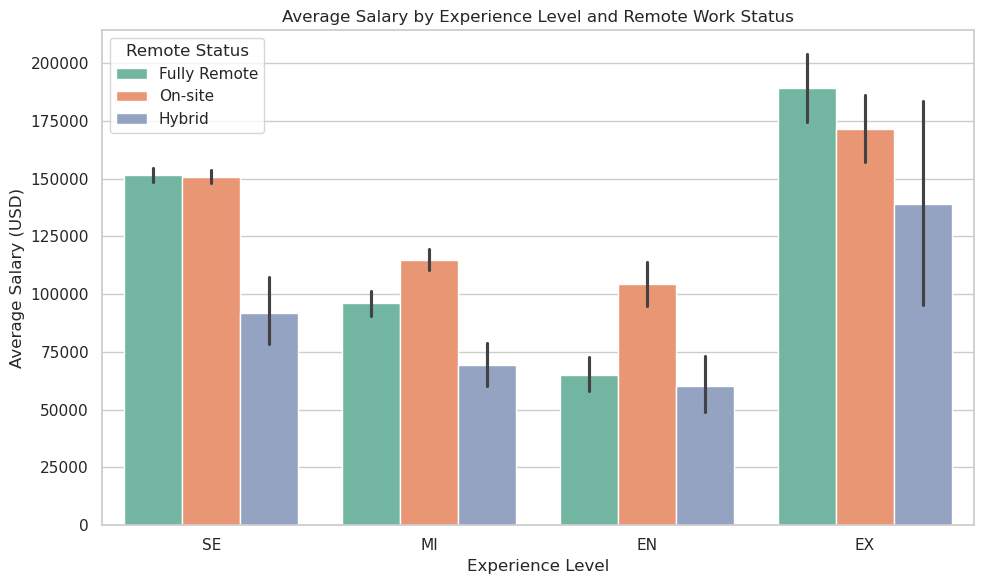

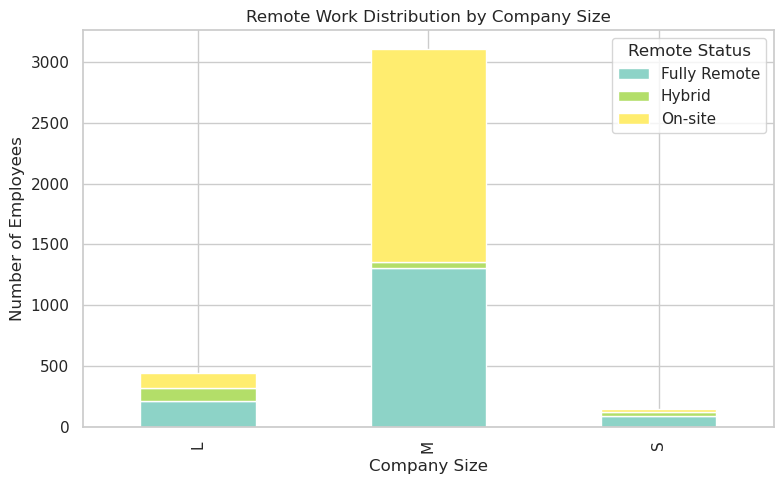

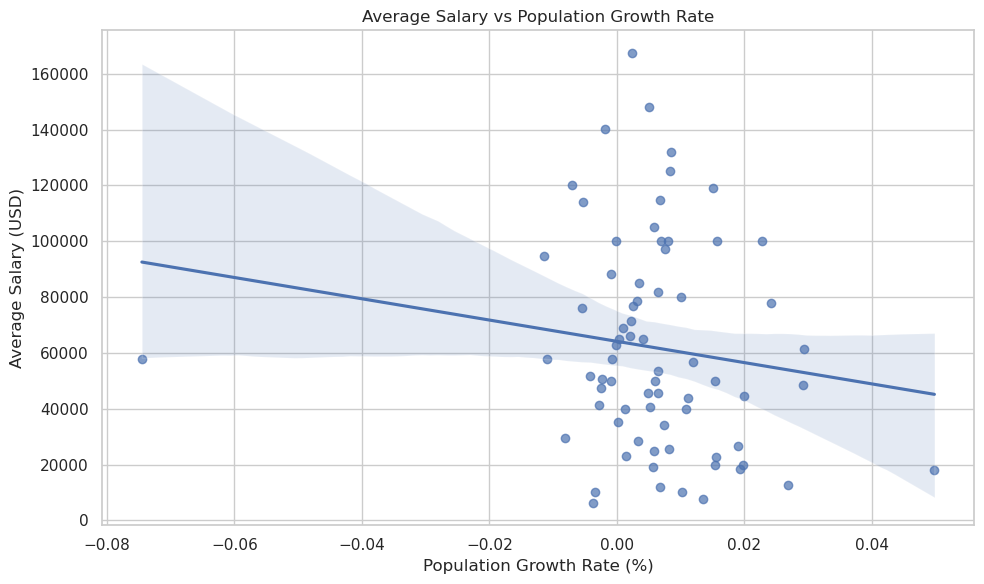

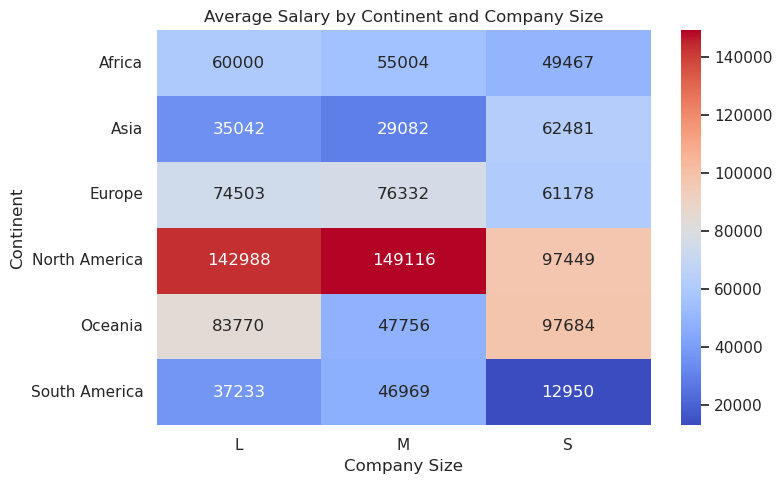

/tmp/ipykernel_142/2888381260.py:248: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=salaries_cleaned, x='work_year', y='salary_in_usd', estimator='mean', ci='sd', marker='o')


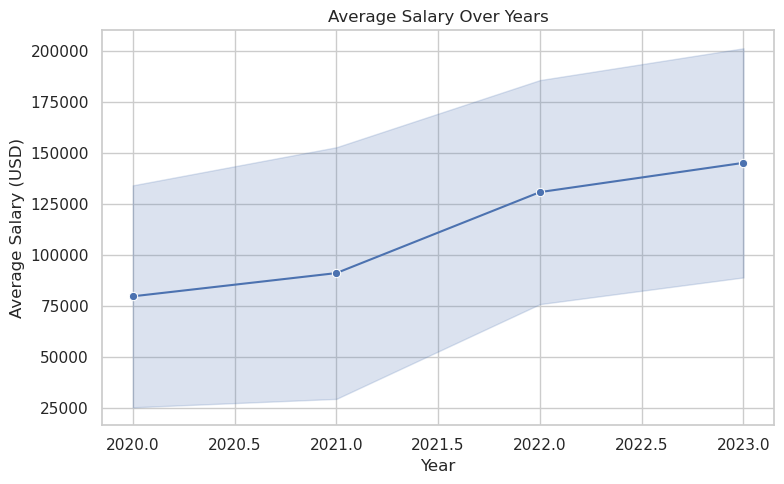

/tmp/ipykernel_142/2888381260.py:263: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


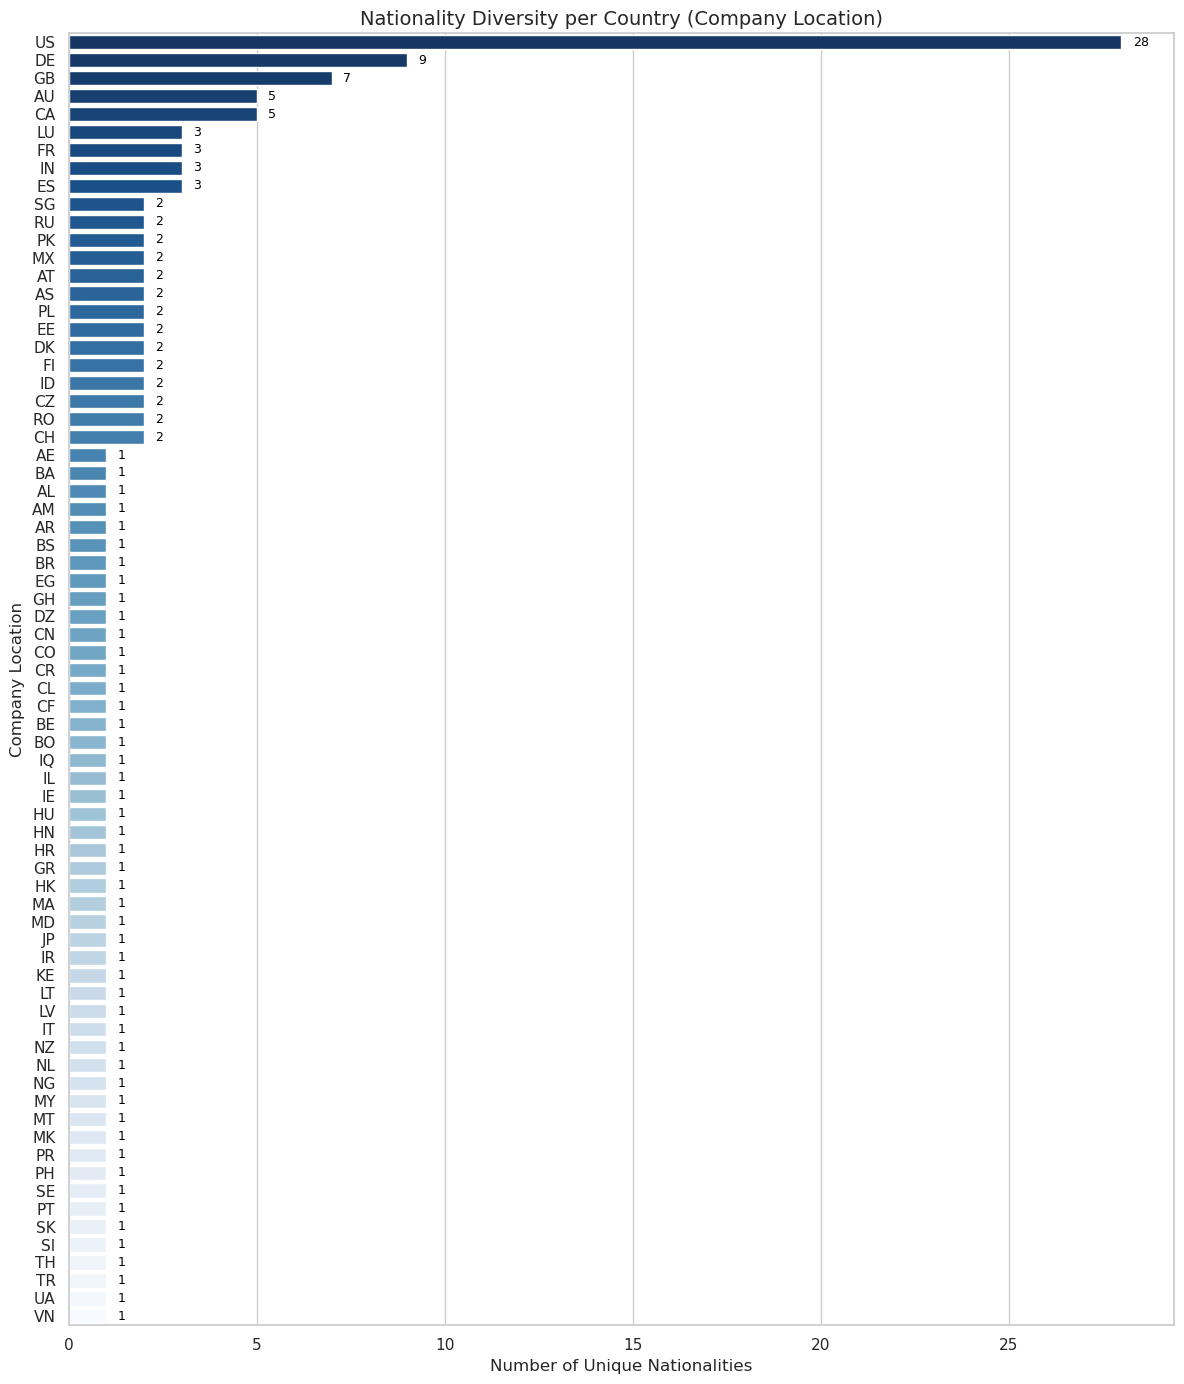

In [12]:
#  Import required libraries
!pip install statsmodels
!pip install pycountry-convert
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pycountry-convert
import pycountry_convert as pc
from scipy import stats 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import pearsonr
#  Load Datasets

salaries = pd.read_csv('ds_salaries_prep.csv')
population = pd.read_csv('countries-table_prep.csv')

#  Prepare Salary Dataset

salaries['remote_status'] = salaries['remote_ratio'].map({0: 'On-site', 50: 'Hybrid', 100: 'Fully Remote'})

#  Add continent info to population dataset

def get_continent_from_cca2(cca2_code):
    try:
        cca2_code = cca2_code.upper()
        continent_code = pc.country_alpha2_to_continent_code(cca2_code)
        continents = {
            'AF': 'Africa',
            'AS': 'Asia',
            'EU': 'Europe',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania',
            'AN': 'Antarctica'
        }
        return continents.get(continent_code, 'Unknown')
    except Exception:
        return 'Unknown'

population['continent'] = population['cca2'].apply(get_continent_from_cca2)

# Fix manually unknown values
manual_fixes = {
    'NAM': 'North America',
    'TLS': 'Asia',
    'ESH': 'Africa',
    'SXM': 'North America',
    'VAT': 'Europe'
}

def update_unknown_continent(row):
    if row['cca3'] in manual_fixes:
        return manual_fixes[row['cca3']]
    else:
        return row['continent']

population['continent'] = population.apply(update_unknown_continent, axis=1)

#Merge
# Step 1: Build subset of population with all needed columns
pop_subset = population[['cca2', 'country', 'continent', 'pop2023', 'growthRate']].copy()
pop_subset.columns = ['country_code', 'country_name', 'continent', 'population', 'growthRate']

# Step 2: Merge safely with salaries on matching country codes
salaries = pd.merge(
    salaries,
    pop_subset,
    left_on='company_location',
    right_on='country_code',
    how='left'
)

# Step 3: Drop temporary column if needed
salaries.drop(columns='country_code', inplace=True)

# Remove outliers using IQR

def remove_outliers_iqr(df, columns):
    df_cleaned = df.copy()
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower) & (df_cleaned[col] <= upper)]
    return df_cleaned

# Apply outlier cleaning
salaries_cleaned = remove_outliers_iqr(salaries, ['salary_in_usd'])

population_cleaned = remove_outliers_iqr(population, [
    'landAreaKm', 'area', 'density', 'growthRate',
    'pop1980', 'pop2000', 'pop2010', 'pop2022',
    'pop2023', 'pop2030', 'pop2050'
])
# ---------------------------------------------------------------
# One-way ANOVA Test:
# This statistical test checks whether there are significant 
# differences in average salary (salary_in_usd) across continents.
# If the p-value is less than 0.05, we can reject the null hypothesis 
# and conclude that at least one continent has a different average salary.
# ---------------------------------------------------------------
# Remove rows with missing continent values
anova_data = salaries_cleaned.dropna(subset=['continent'])

# Create a list of salary arrays grouped by continent
# Each item in 'groups' will be a numpy array of salaries from one continent
groups = [group['salary_in_usd'].values for name, group in anova_data.groupby('continent')]

# Perform one-way ANOVA test
f_stat, p_value = stats.f_oneway(*groups)

# Print results
print("ANOVA Test Results:")
print(f"F-statistic: {f_stat:.2f}")   # The larger this is, the more likely the groups differ
print(f"P-value: {p_value:.4f}")      # Tells us whether the difference is statistically significant

# Interpret the result
if p_value < 0.05:
    print("Conclusion: There is a statistically significant difference in average salaries between continents.")
 # Run Tukey HSD post-hoc test
    tukey_data = salaries_cleaned.dropna(subset=['continent'])
    salaries = tukey_data['salary_in_usd']
    continents = tukey_data['continent']
    
    tukey_result = pairwise_tukeyhsd(endog=salaries, groups=continents, alpha=0.05)
    print(tukey_result)

else:
    print("Conclusion: There is no statistically significant difference in average salaries between continents.")

# Pearson Correlation Test: relationship between population growth rate and average salary

# Calculate average salary per country 
avg_salary = salaries_cleaned.groupby('company_location')['salary_in_usd'].mean().reset_index()
avg_salary.columns = ['company_location', 'average_salary']

corr_data = salary_pop_growth.dropna(subset=['growthRate', 'avg_salary'])

corr_coef, corr_p_value = pearsonr(corr_data['growthRate'], corr_data['avg_salary'])

print("\nPearson Correlation Test:")
print(f"Correlation coefficient: {corr_coef:.3f}")
print(f"P-value: {corr_p_value:.4f}")
if p_value < 0.05:
    print("Conclusion: There is a statistically significant relationship between population growth rate and average salary per country.")
else:
    print("Conclusion: No statistically significant relationship was found between population growth rate and average salary per country.")

#  Reusable Plotting Function

def plot_avg_salary_by_column(df, column, title, figsize=(10, 5)):
    avg_salary = df.groupby(column)['salary_in_usd'].mean().sort_values(ascending=False)
    plt.figure(figsize=figsize)
    sns.barplot(x=avg_salary.values, y=avg_salary.index, palette='crest')
    plt.title(title)
    plt.xlabel('Average Salary (USD)')
    plt.ylabel(column)
    plt.show()
    
# Save cleaned datasets to CSV files
salaries_cleaned.to_csv('salaries_cleaned.csv', index=False)
population_cleaned.to_csv('population_cleaned.csv', index=False)

# Salary Analyses
plot_avg_salary_by_column(salaries_cleaned, 'experience_level', 'Average Salary by Experience Level')
plot_avg_salary_by_column(salaries_cleaned, 'company_size', 'Average Salary by Company Size')
plot_avg_salary_by_column(salaries_cleaned, 'remote_status', 'Average Salary by Remote Work Status')
plot_avg_salary_by_column(salaries_cleaned.dropna(subset=['continent']), 'continent', 'Average Salary by Continent')

# Salary vs Population (Scatter)
avg_salary_by_country = salaries_cleaned.groupby('company_location')['salary_in_usd'].mean().reset_index()
avg_salary_by_country.columns = ['country_code', 'avg_salary']
salary_pop_merged = pd.merge(avg_salary_by_country, pop_subset, on='country_code', how='inner')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=salary_pop_merged, x='population', y='avg_salary', hue='country_name')
plt.title('Average Salary vs Country Population')
plt.xlabel('Population (2023)')
plt.ylabel('Average Salary (USD)')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Boxplot to show salary distribution by continent (log scale for better visualization)
plt.figure(figsize=(10, 6))
sns.boxplot(data=salaries_cleaned.dropna(subset=['continent']), x='continent', y='salary_in_usd', palette='pastel')
plt.yscale('log')  # log scale helps with skewed salary data
plt.title('Salary Distribution by Continent (Log Scale)')
plt.xlabel('Continent')
plt.ylabel('Salary (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Average Salary by Experience Level and Remote Work Status
plt.figure(figsize=(10, 6))
sns.barplot(data=salaries_cleaned, x='experience_level', y='salary_in_usd', hue='remote_status', palette='Set2')
plt.title('Average Salary by Experience Level and Remote Work Status')
plt.xlabel('Experience Level')
plt.ylabel('Average Salary (USD)')
plt.legend(title='Remote Status')
plt.tight_layout()
plt.show()

# Count of remote statuses by company size
remote_company_ct = salaries_cleaned.groupby(['company_size', 'remote_status']).size().unstack()

remote_company_ct.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set3')
plt.title('Remote Work Distribution by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Number of Employees')
plt.legend(title='Remote Status')
plt.tight_layout()
plt.show()

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=salary_pop_growth, x='growthRate', y='avg_salary', scatter_kws={"alpha": 0.7})
plt.title('Average Salary vs Population Growth Rate')
plt.xlabel('Population Growth Rate (%)')
plt.ylabel('Average Salary (USD)')
plt.tight_layout()
plt.show()

# Pivot table: Average salary by continent and company size
pivot_table = salaries_cleaned.pivot_table(
    values='salary_in_usd',
    index='continent',
    columns='company_size',
    aggfunc='mean'
)

# Heatmap of average salary
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='coolwarm')
plt.title('Average Salary by Continent and Company Size')
plt.xlabel('Company Size')
plt.ylabel('Continent')
plt.tight_layout()
plt.show()

# Average salary per year
plt.figure(figsize=(8,5))
sns.lineplot(data=salaries_cleaned, x='work_year', y='salary_in_usd', estimator='mean', ci='sd', marker='o')
plt.title('Average Salary Over Years')
plt.xlabel('Year')
plt.ylabel('Average Salary (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Nationality diversity per company location
nationality_diversity = salaries_cleaned.groupby('company_location')['employee_residence'].nunique().sort_values(ascending=False)

# Create barplot
plt.figure(figsize=(12, 14))  # larger figure for better readability
sns.set(style='whitegrid')

ax = sns.barplot(
    x=nationality_diversity.values,
    y=nationality_diversity.index,
    palette='Blues_r'  # cleaner color map
)

# Add numbers on bars
for i, v in enumerate(nationality_diversity.values):
    ax.text(v + 0.3, i, str(v), color='black', va='center', fontsize=9)

# Title and labels
plt.title('Nationality Diversity per Country (Company Location)', fontsize=14)
plt.xlabel('Number of Unique Nationalities', fontsize=12)
plt.ylabel('Company Location', fontsize=12)
plt.tight_layout()
plt.show()
   


